#Introduction
This notebook demonstrates how to solve the face age prediction problem using a deep learning approach with a pre-trained model (VGG16) and transfer learning. In a previous notebook, we tackled this problem using linear regression, but now we aim to leverage deep learning to achieve better accuracy and handle the complexity of image data more effectively.

In [1]:
# Importing necessary libraries for image processing, machine learning, and deep learning
import numpy as np
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


#Data Loading and Preprocessing
In this section, we will load the images from the dataset, resize them to a consistent shape, and normalize the pixel values. Each image will be labeled with the age group (represented by the folder name), which is the target for prediction.

In [2]:
# Loading the images folder in the working directory
!wget https://www.lamsade.dauphine.fr/~ychevaleyre/data/face_age.zip
!unzip face_age.zip

# Function to load and preprocess images from folder structure
def load_images_from_folder(base_dir):
    images = []
    labels = []

    # Iterate over each folder in the base directory (each folder name is the age label)
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)

        # Only process folders (ignore files)
        if not os.path.isdir(folder_path):
            continue

        # The folder name represents the age (convert to integer)
        age = int(folder_name)

        # Load all images in the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            if not img_name.endswith(('.jpg', '.jpeg', '.png')):
                continue  # Skip non-image files

            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Image at {img_path} could not be loaded.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (100, 100))  # Resize to 100x100
            img = img / 255.0  # Normalize image (scale pixel values to [0, 1])

            images.append(img)
            labels.append(age)

    # Convert to numpy arrays
    return np.array(images), np.array(labels)

# Defining the base directory where your face_age folder is located
base_dir = 'face_age'

# Loading images and labels
X, Y = load_images_from_folder(base_dir)

# Checkng the shape of loaded data
print("Loaded image data:", X.shape)
print("Loaded labels:", Y.shape)

Streaming output truncated to the last 5000 lines.
  inflating: face_age/003/8189.png   
  inflating: __MACOSX/face_age/003/._8189.png  
  inflating: face_age/003/5687.png   
  inflating: __MACOSX/face_age/003/._5687.png  
  inflating: face_age/003/3396.png   
  inflating: __MACOSX/face_age/003/._3396.png  
  inflating: face_age/003/7655.png   
  inflating: __MACOSX/face_age/003/._7655.png  
  inflating: face_age/003/8758.png   
  inflating: __MACOSX/face_age/003/._8758.png  
  inflating: face_age/003/1027.png   
  inflating: __MACOSX/face_age/003/._1027.png  
  inflating: face_age/003/4639.png   
  inflating: __MACOSX/face_age/003/._4639.png  
  inflating: face_age/003/4177.png   
  inflating: __MACOSX/face_age/003/._4177.png  
  inflating: face_age/003/3426.png   
  inflating: __MACOSX/face_age/003/._3426.png  
  inflating: face_age/003/1557.png   
  inflating: __MACOSX/face_age/003/._1557.png  
  inflating: face_age/003/9686.png   
  inflating: __MACOSX/face_age/003/._9686.png  
  i

#Splitting the Data
Now that we have loaded and preprocessed the data, we will split the dataset into training and testing sets. This split allows us to train the model on a portion of the data and evaluate its performance on unseen data.

In [3]:
# Splitting data into train and test sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Checking the shapes of the split data
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (7822, 100, 100, 3)
Test data shape: (1956, 100, 100, 3)


#Model Creation with Transfer Learning
In this section, we will use a pre-trained VGG16 model as a feature extractor. VGG16 has been trained on a large dataset (ImageNet), so it can identify useful features for many types of images, including face images. We will freeze the layers of the pre-trained model and add a custom fully connected layer for age prediction.

In [4]:
# Loading the VGG16 model pre-trained on ImageNet, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freezing the base model layers so they are not updated during training
base_model.trainable = False

# Creating a new model with a custom top layer for age prediction
transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer for predicting age (single continuous value)
])

# Compiling the model
transfer_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Training the Model
We are now ready to train the model. We'll train the model for 20 epochs using the training data. We'll also validate the model on the test set during training to check for overfitting.

In [5]:
# Training the transfer model
history = transfer_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1162s 5s/step - loss: 489.2928 - mae: 17.1998 - val_loss: 214.5589 - val_mae: 10.8588
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1125s 5s/step - loss: 223.0107 - mae: 11.0979 - val_loss: 200.8468 - val_mae: 10.1412
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1162s 5s/step - loss: 195.7416 - mae: 10.3207 - val_loss: 175.6773 - val_mae: 9.6284
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1161s 5s/step - loss: 181.7569 - mae: 9.9385 - val_loss: 166.4230 - val_mae: 9.3459
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1199s 5s/step - loss: 170.1080 - mae: 9.4738 - val_loss: 160.2274 - val_mae: 9.2247
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1124s 5s/step - loss: 164.7637 - mae: 9.2949 - val_loss: 156.4605 - val_mae: 9.0655
Epoch 7/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1124s 5s/step - loss: 156.7035 - mae: 9.0517 - val_loss: 161.8059 - val_mae: 9.0009
Epoch 8/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1161s 5s/step - loss: 145.5050 - mae: 8.7107 - val_loss: 155.4901 - val_mae: 8.8678
Epo

#Visualizing the Training History
We can now visualize the model's performance by plotting the loss and mean absolute error (MAE) over the epochs. This will give us an insight into how well the model is learning and if it's overfitting or underfitting.

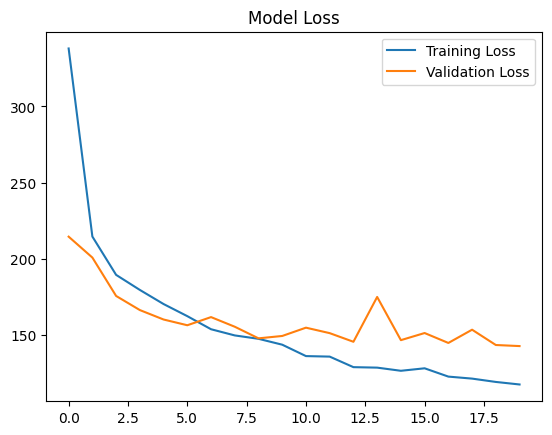

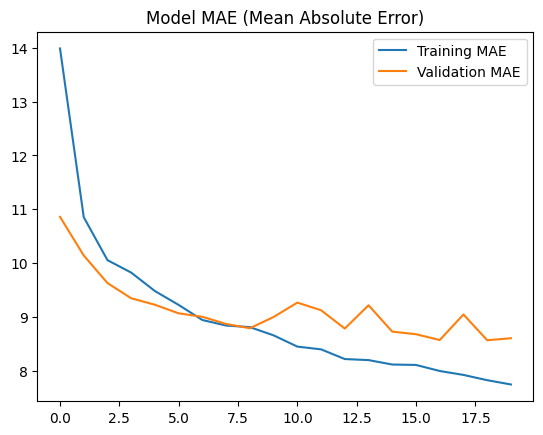

In [6]:
# Displaying training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title("Model MAE (Mean Absolute Error)")
plt.show()


#Evaluating the Model
Now that the model is trained, we will evaluate it on the test set to check its final performance. We will use Mean Absolute Error (MAE) as our metric for evaluating the age prediction accuracy.


In [7]:
# Evaluating the model on the test set
test_loss, test_mae = transfer_model.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE (Mean Absolute Error): {test_mae}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - loss: 134.8831 - mae: 8.3254
Test Loss: 142.80178833007812
Test MAE (Mean Absolute Error): 8.602514266967773


#Making Predictions
Finally, we can use the trained model to make predictions on new data (such as images from the test set). This will help us to see how well the model generalizes to unseen data.

In [8]:
# Example of making predictions on new data (X_test or new images)
predictions = transfer_model.predict(X_test)

print(f"Predictions: {predictions}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step
Predictions: [[43.494694 ]
 [50.041534 ]
 [18.709284 ]
 ...
 [ 5.4661393]
 [35.940636 ]
 [ 1.1527969]]


#Conclusion
In this notebook, we used transfer learning with the pre-trained VGG16 model to solve the face age prediction problem. By fine-tuning the model with a custom fully connected layer for age prediction, we were able to "better" predict the age of individuals from facial images. In comparison to the linear regression approach used in the previous notebook, this deep learning method should provide more accurate results, especially for image data.

#Credits

Data provided by Yann Chevaleyre.
Analysis and implementation by Mohamed ZOUAD.